In [ ]:
#default_exp face_dataset_unlabeled

In [11]:
#export
from fastai import *
from fastai.vision import *
from pathlib import Path
import cv2

In [12]:
#export
import pickle

def read_dict(path):
    with open(path, 'rb') as handle:
        unserialized_data = pickle.load(handle)
    return unserialized_data

def save_dict(dictionary, path):
    with open(path, 'wb') as handle:
        pickle.dump(dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

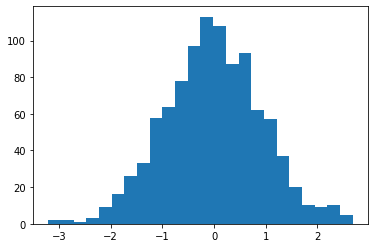

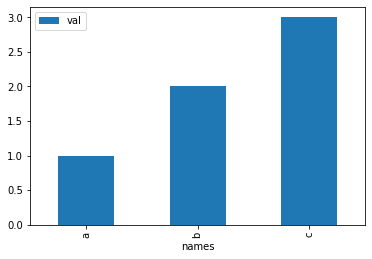

In [13]:
import matplotlib.pyplot as plt

def plot(im, figsize=None): # im - np.arr(h,w,3), figsize - tuple(2)
    ax = plt.figure(figsize=figsize)
    if len(im.squeeze().shape) == 2: plt.imshow(im, cmap='gray')
    else: plt.imshow(im)
    return plt.show()

def plot_histogram(arr, title=None): # arr of size [n]
    _ = plt.hist(arr, bins='auto')  # arguments are passed to np.histogram
    plt.title(title)
    plt.show()
    
def plot_categories(names, values, title='names'): # arr of size [n]
    df = pd.DataFrame({title:listify(names), 'val':listify(values)})
    df.plot.bar(x=title, y='val', rot=90)

plot_histogram( np.random.RandomState(10).normal(size=1000) )
plot_categories(['a','b','c'], [1,2,3])

In [14]:
#export
# if value is None then it is skipped
expression_map_default = {
    'Unspecified': 0,
    'Neutral': 1,
    'Smile': 2,
    'SmileOpenedJaw': 3,
    'RaisedBrows': 4,
    'EyesAway': 5,
    'Squinting': 6,
    'Frowning': 7,
    'Unknown': 0
}
gender_map_default = {
    'Unspecified': 0,
    'Unknown': 0,
    'Male': 1,
    'Female': 2
}
icao_map_default = {
    'None': 0,
    'FaceNotDetected': 1,
    'RollLeft': 2,'RollRight': 3,'YawLeft': 4,'YawRight': 5,'PitchUp': 6,'PitchDown': 7,
    'TooNear': 8,'TooFar': 9,'TooNorth': 10,'TooSouth': 11,'TooEast': 12,'TooWest': 13,
    'Sharpness': 14,
    'BackgroundUniformity': 15,
    'GrayscaleDensity': 16,
    'Saturation': 17,
    'Expression': 18,
    'DarkGlasses':19,
    'Blink': 20,
    'MouthOpen': 21,
    'LookingAway': 22,
    'RedEye': 23,
    'FaceDarkness': 24,
    'UnnaturalSkinTone': 25,
    'WashedOut': 26,
    'Pixelation': 27,
    'SkinReflection': 28,
    'GlassesReflection': 29
}
properties_map_default = {
    'NotSpecified': 0,
    'Specified': 0,
    'Glasses': 1,
    'Mustache': 2,
    'Beard': 3,
    'TeethVisible': 4,
    'Blink': 5,
    'MouthOpen': 6,
    'LeftEyePatch': 7,
    'RightEyePatch': 8,
    'BothEyePatch': 9,
    'DarkGlasses': 10,
    'DistortingCondition': 11,
    'Hat': 12,
    'Scarf': 13,
    'NoEar': 14
}

In [15]:
#export
# format: (type,default_number,...)
# default_number: if number == 254 and is scalar: then swap it with this number
#   if number is multi: then this value is a map from values to labels {'1': 'true', '2': 'unknown', '3': 'true',...}
lbl_config = {
 'Age': ('scalar', 1, 2),
 'BackgroundUniformity': ('scalar', 1, 2),
 'BeardConfidence': ('scalar', 1, 2),
 'BlinkConfidence': ('scalar', 1, 2),
 'Contrast': ('scalar', 1, 2),
 'DarkGlassesConfidence': ('scalar', 1, 2),
 'DetectionConfidence': ('scalar', 1, 2),
 'EmotionAngerConfidence': ('scalar', 1, 2),
 'EmotionContemptConfidence': ('scalar', 1, 2),
 'EmotionDisgustConfidence': ('scalar', 1, 2),
 'EmotionFearConfidence': ('scalar', 1, 2),
 'EmotionHappinessConfidence': ('scalar', 1, 2),
 'EmotionNeutralConfidence': ('scalar', 1, 2),
 'EmotionSadnessConfidence': ('scalar', 1, 2),
 'EmotionSurpriseConfidence': ('scalar', 1, 2),
 'EthnicityAsianConfidence': ('scalar', 1, 2),
 'EthnicityBlackConfidence': ('scalar', 1, 2),
 'EthnicityHispanicConfidence': ('scalar', 1, 2),
 'EthnicityIndianConfidence': ('scalar', 1, 2),
 'EthnicityWhiteConfidence': ('scalar', 1, 2),
 'ExpressionConfidence': ('scalar', 1, 2),
 'FaceDarknessConfidence': ('scalar', 1, 2),
 'GenderConfidence': ('scalar', 1, 2),
 'GlassesConfidence': ('scalar', 1, 2),
 'GlassesReflectionConfidence': ('scalar', 1, 2),
 'GrayscaleDensity': ('scalar', 1, 2),
 'HatConfidence': ('scalar', 1, 2),
 'LivenessScore': ('scalar', 1, 2),
 'LivenessTargetPitch': ('scalar', 1, 2),
 'LivenessTargetYaw': ('scalar', 1, 2),
 'LookingAwayConfidence': ('scalar', 1, 2),
 'MouthOpenConfidence': ('scalar', 1, 2),
 'MustacheConfidence': ('scalar', 1, 2),
 'Noise': ('scalar', 1, 2),
 'Pitch': ('scalar float', 1, 2),
 'PixelationConfidence': ('scalar', 1, 2),
 'Quality': ('scalar', 1, 2),
 'RedEyeConfidence': ('scalar', 0, 2),
 'Roll': ('scalar float', 1, 2),
 'Saturation': ('scalar', 1, 2),
 'Sharpness': ('scalar', 1, 2),
 'SkinReflectionConfidence': ('scalar', 1, 2),
 'UnnaturalSkinToneConfidence': ('scalar', 1, 2),
 'WashedOutConfidence': ('scalar', 1, 2),
 'Yaw': ('scalar float', 1, 2),
 'Expression': ('multi', expression_map_default, 2),
 'Gender': ('multi', gender_map_default, 2),
 'IcaoWarnings': ('multi', icao_map_default, 2),
 'LivenessAction': ('multi', None, 2),
 'Properties': ('multi', properties_map_default, 2),
 'BoundingRect': ('bbox', 1, 2),
 'FeaturePoints': ('pts', 1, 2),
 'LeftEyeCenter': ('pt', 1, 2),
 'MouthCenter': ('pt', 1, 2),
 'NoseTip': ('pt', 1, 2),
 'RightEyeCenter': ('pt', 1, 2)
}

In [16]:
#export
icao_warnings = [
 'TooSouth',
 'TooFar',
 'RedEye',
 'YawRight',
 'TooEast',
 'SkinReflection',
 'UnnaturalSkinTone',
 'MouthOpen',
 'RollRight',
 'TooNear',
 'RollLeft',
 'Sharpness',
 'None',
 'TooNorth',
 'DarkGlasses',
 'GrayscaleDensity',
 'PitchDown',
 'Blink',
 'FaceDarkness',
 'LookingAway',
 'GlassesReflection',
 'WashedOut',
 'Expression',
 'Saturation',
 'TooWest',
 'Pixelation',
 'YawLeft',
 'PitchUp'
]

In [17]:
# Expression Unknown
# Gender Unspecified
# LivenessAction None
# Properties Glasses, DarkGlasses

In [18]:
#export
class config:
    DICT_PATH = "../data/face/unlabeled_fn2label.pkl"
    FACE_PATH = Path("/data/faces/")
    PATH = FACE_PATH/"unlabeled"
    IM_PATH = PATH/"images"
    CROPPED_IM_PATH = Path("../data/face/unlabeled_cropped_images/")
    CROPPED_DICT_PATH = Path("../data/face/unlabeled_cropped_fn2label.pkl")

In [19]:
#export
FACE_PATH = Path("/data/faces/")
PATH = FACE_PATH/"unlabeled"
IM_PATH = PATH/"images"
DNAMES = ['sof', 'lfw', 'fc', 'bioid', 'wiki', 'imdb_0', 'imdb_1']

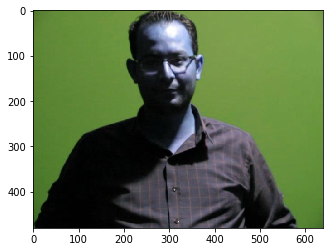

In [20]:
plot(cv2.imread(str(IM_PATH/"sof_405.jpg")))

In [21]:
read_json = lambda data_name: json.load(open(PATH/("labels_"+data_name+".txt")))
read_image_cv2 = lambda im_path: cv2.cvtColor(cv2.imread(str(IM_PATH/im_path)), cv2.COLOR_BGR2RGB)

In [22]:
def parse_points(pts_string):
    ''' 'x,y,w,h' or 'x,y' '''
    return list(map(int, pts_string.split(',')))
    
def parse_feat_points(pts_string):
    ''' in form of: 'x,y|x,y|...' '''
    return [parse_points(pts) for pts in pts_string.split('|')]

In [23]:
def parse_multi(icao_string):
    return [i.replace(' ','') for i in icao_string.split(',')]

In [24]:
#export
pry_lbl2int = {'Pitch': 0, 'Roll': 1, 'Yaw': 2}
pitch_roll_yaw_mean = tensor([-8,0,0])
pitch_roll_yaw_std = tensor([6,6,8])

In [25]:
def preprocess_answer(label, answer): # preprocess one answer
    config = lbl_config[label]
    if config[1] is None: return answer
    if 'scalar' in config[0]:
        if answer > 250: answer = config[1]
        if 'float' not in config[0]: answer = answer / 100.
    if 'multi' in config[0]:
        answer = list(set([config[1][lbl] for lbl in parse_multi(answer)]))
    if 'pt' == config[0] or 'bbox' in config[0]:
        answer = parse_points(answer)
    if 'pts' == config[0]:
        answer = parse_feat_points(answer)
#     if label in ['Pitch','Roll','Yaw']:
#         i = pry_lbl2int[label]
#         answer = (answer - pitch_roll_yaw_mean[i]) / pitch_roll_yaw_std[i]
    return answer

In [26]:
def preprocess_face(face): # preprocess all answers in face
    for label, l_id in lbl2id.items():
        answer = face[l_id]
        face[l_id] = preprocess_answer(label, answer)
    return face

#### tests

In [27]:
args = read_json('sof')['face_args']
def test_args():
    for data_name in DNAMES:
        assert (args == read_json(data_name)['face_args'])

test_args()
lbl2id = {v:k for k,v in args.items()}

In [28]:
def test_faces_len():
    for data_name in progress_bar(DNAMES):
        for j in read_json(data_name)['images']:
            path, faces = j['path'], j['faces']
            assert (len(faces) == 2)
test_faces_len()

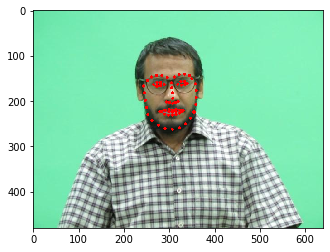

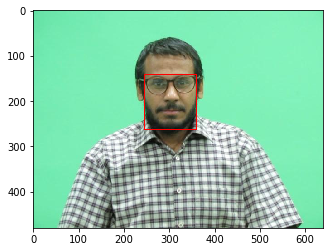

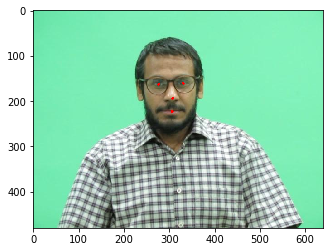

In [29]:
for j in read_json('sof')['images']:
    im_orig, (face1, face2) = read_image_cv2(j['path']), j['faces']
    # feature points
    im = im_orig.copy()
    points = face1[lbl2id['FeaturePoints']]
    pts = parse_feat_points(points)
    for p in pts:
        im = cv2.circle(im, tuple(map(int, p)), 2, 255, 2)
    plot(im)
    # 
    im = im_orig.copy()
    points = face1[lbl2id['BoundingRect']]
    bb = parse_points(points)
    t,l,b,r = bb[0],bb[1],bb[2],bb[3]
    im = cv2.rectangle(im, (l,t), (r,b), 255, 2) 
    plot(im)
    # other
    im = im_orig.copy()
    other_pts = list(map(lambda p: parse_points(face1[lbl2id[p]]), ['LeftEyeCenter','RightEyeCenter','MouthCenter','NoseTip']))
    for p in other_pts:
        im = cv2.circle(im, tuple(map(int, p)), 2, 255, 2)
    plot(im)
    break

In [31]:
# hypothesis: icao2 is subset of icao2
def get_icaos_list():
    icaos = set()
    for data_name in progress_bar(DNAMES):
        for j in read_json(data_name)['images'][:10]:
            face1, face2 = j['faces']
            face1, face2 = preprocess_face(face1), preprocess_face(face2)
            for label, l_id in lbl2id.items():
                answer = face1[l_id]
                if lbl_config[label][0] == 'scalar': scalar_stats[label].append(float(answer))
            icao1, icao2 = face1[lbl2id['IcaoWarnings']], face2[lbl2id['IcaoWarnings']]
            icao1, icao2 = parse_multi(icao1), parse_multi(icao2)
            for i in icao1 + icao2: icaos.add(i)
            assert len(icao1) >= len(icao2) # hypothesis?
    return list(icaos)

# icaos = get_icaos_list()

In [32]:
# face 2 has and face 1 not:
# Contrast
# Noise
# Quality

# face 1 has and face 2 not:
# DetectionConfidence
# Pitch, Roll, Yaw

# noone has:
# MustacheConfidence
# LivenessTargetYaw
# LivenessTargetPitch
# LivenessScore
# HatConfidence
# GenderConfidence
# Ethnicity...
# Emotion...
# BeardConfidence
# Age

In [33]:
def get_stats(preprocess=False):
    scalar_stats = defaultdict(lambda: [])
    multi_stats = defaultdict(lambda: defaultdict(lambda: 0))
    total_images = 0
    for data_name in progress_bar(DNAMES):
        for j in read_json(data_name)['images']:
#             im = read_image_cv2(j['path'])
            face1, face2 = j['faces']
            if preprocess: face1, face2 = preprocess_face(face1), preprocess_face(face2)
            total_images += 1
            for label, l_id in lbl2id.items():
                face = face2 if label in ['Contrast','Noise','Quality'] else face1
                answer = face[l_id]
                # append to stats
                if 'scalar' in lbl_config[label][0]: scalar_stats[label].append(float(answer))
                if 'multi' in lbl_config[label][0]: 
                    for lbl in answer: multi_stats[label][lbl] += 1
    return map(dict, [scalar_stats, multi_stats]), total_images

In [34]:
# face 2 has and face 1 not:
# Contrast
# Noise
# Quality

# face 1 has and face 2 not:
# DetectionConfidence
# Pitch, Roll, Yaw

# noone has:
# MustacheConfidence
# LivenessTargetYaw
# LivenessTargetPitch
# LivenessScore
# HatConfidence
# GenderConfidence
# Ethnicity...
# Emotion...
# BeardConfidence
# Age

In [35]:
(scalar_stats, multi_stats), total_images = get_stats(preprocess=True)
print('total:', total_images)

total: 193741


In [36]:
# multi_stats

Gender has only 1 class


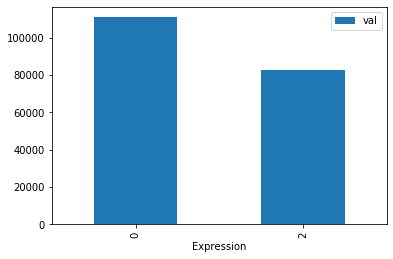

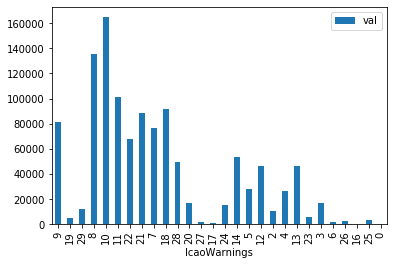

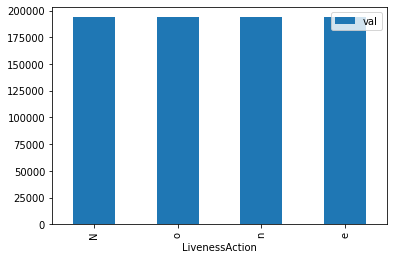

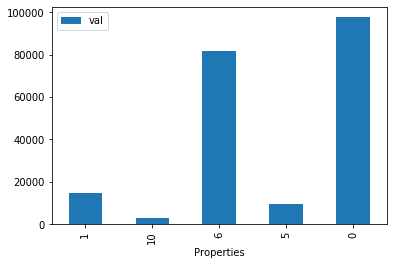

In [37]:
for label, stats in multi_stats.items():
    if len(stats.keys()) == 1: print(label, 'has only 1 class')
    else: plot_categories(stats.keys(), stats.values(), title=label)

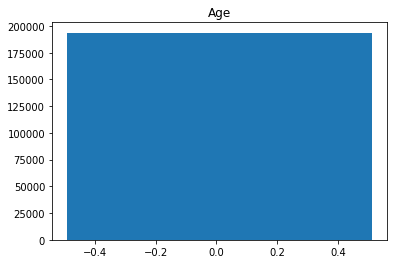

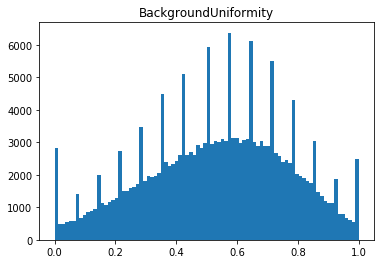

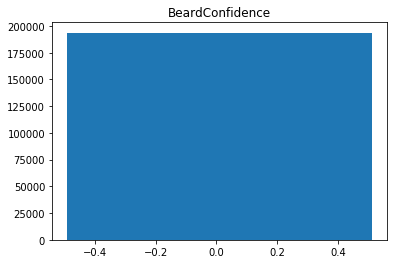

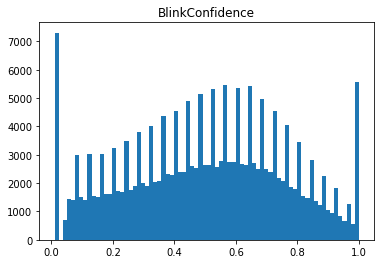

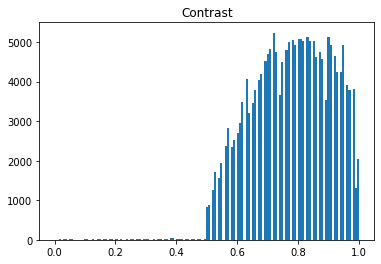

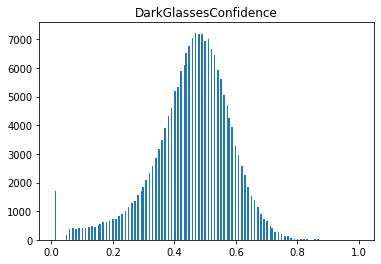

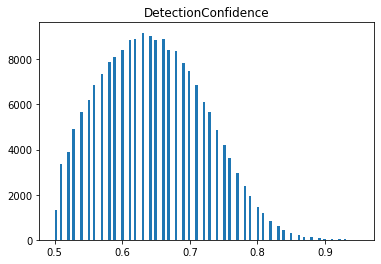

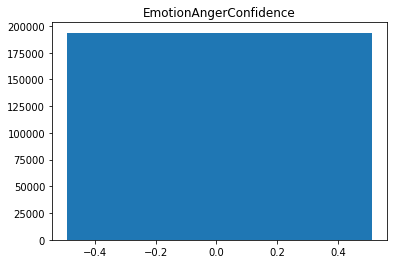

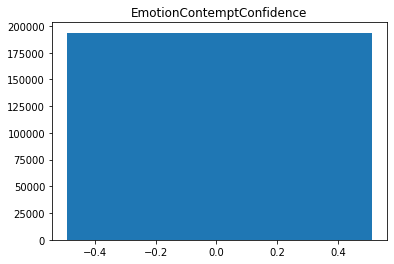

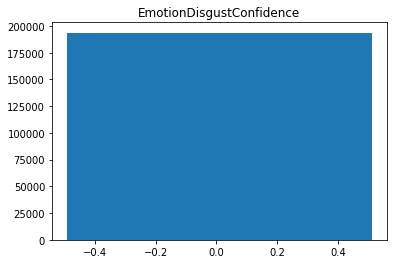

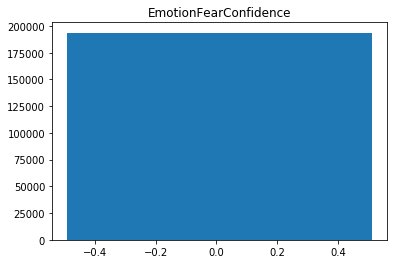

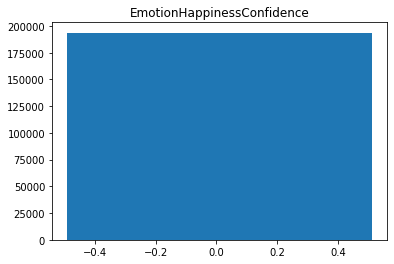

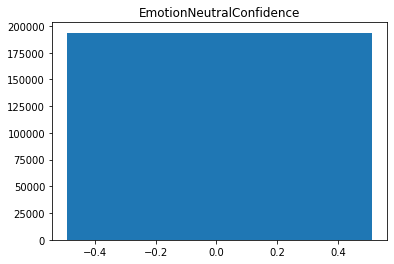

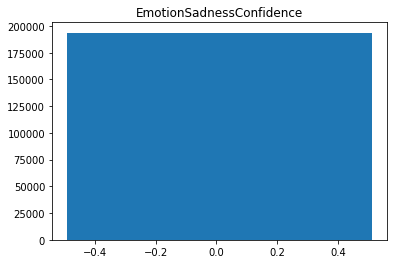

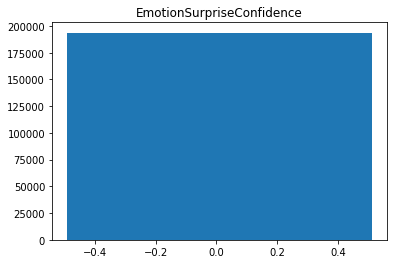

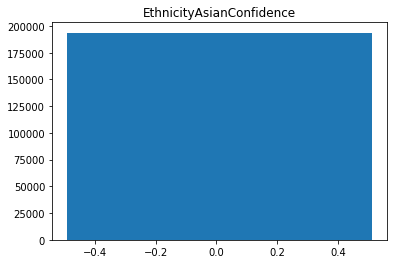

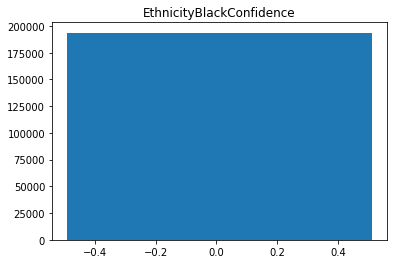

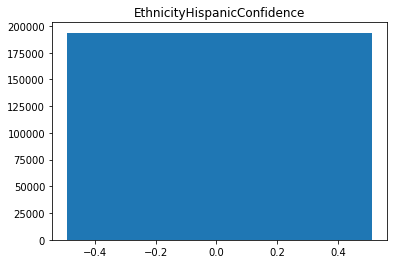

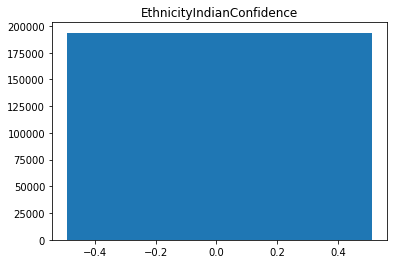

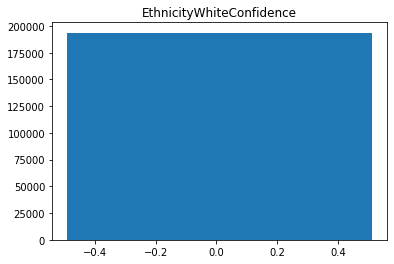

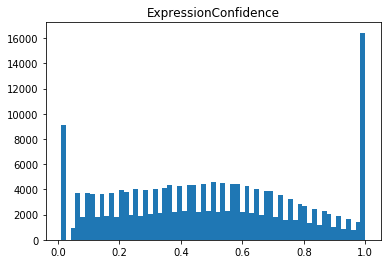

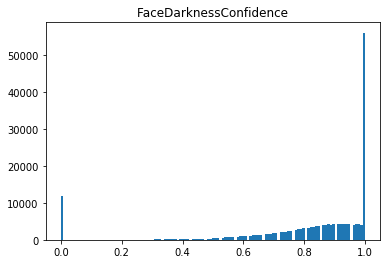

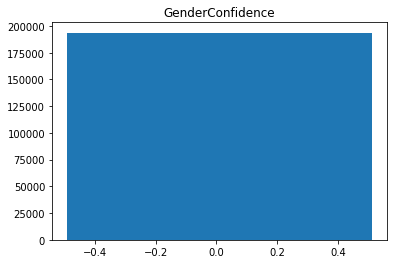

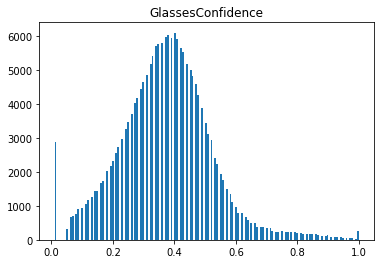

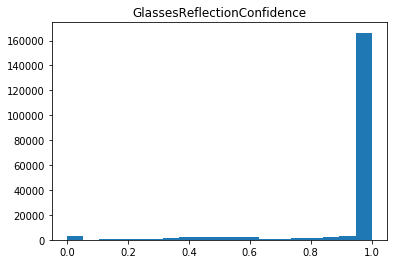

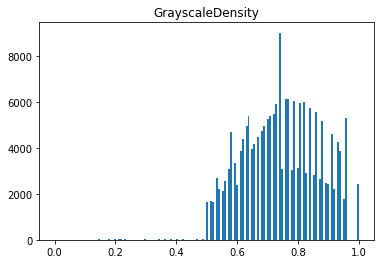

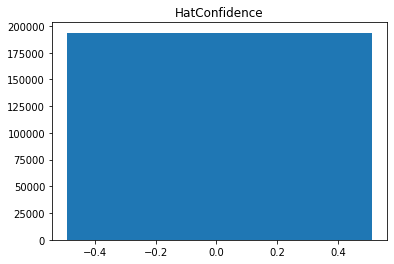

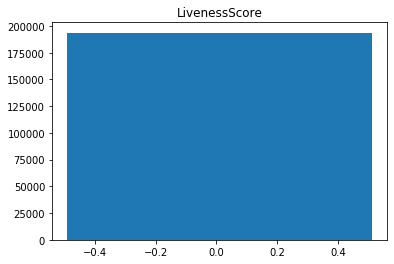

LivenessTargetPitch is not labeled
LivenessTargetYaw is not labeled


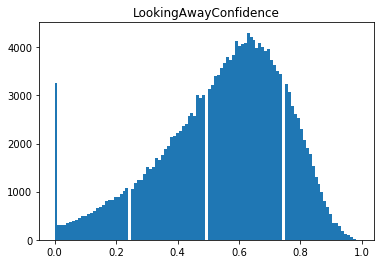

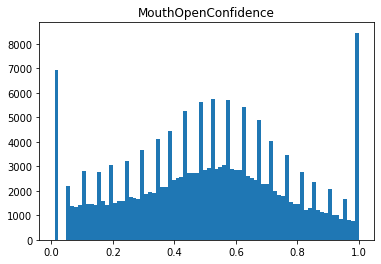

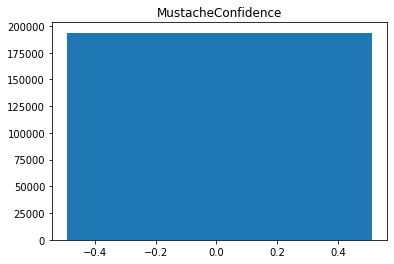

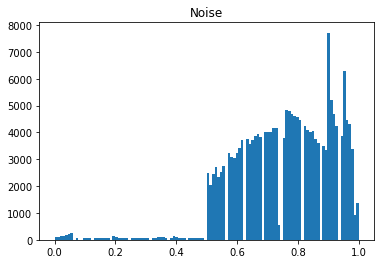

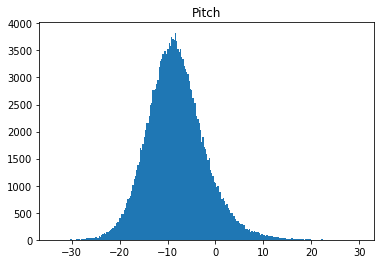

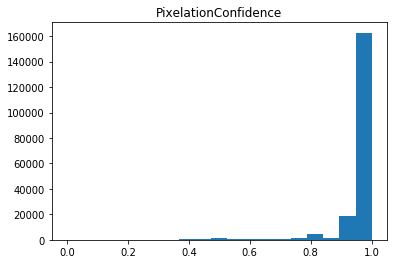

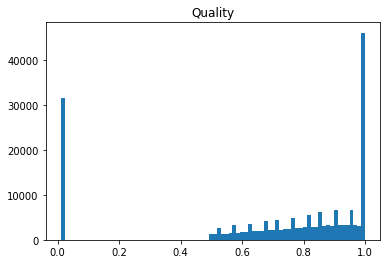

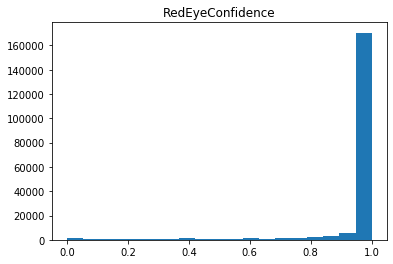

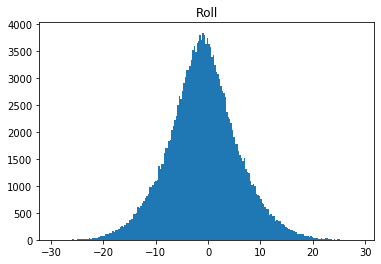

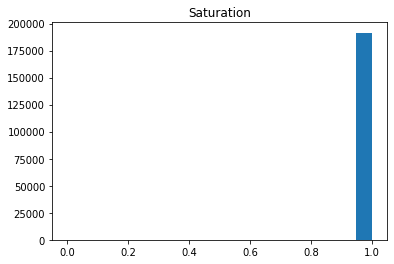

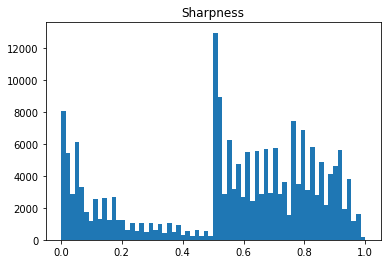

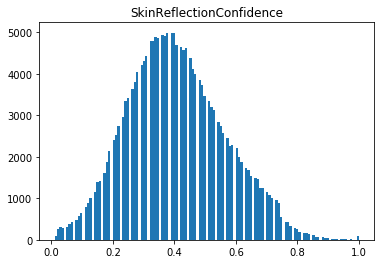

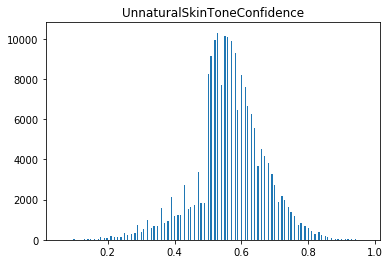

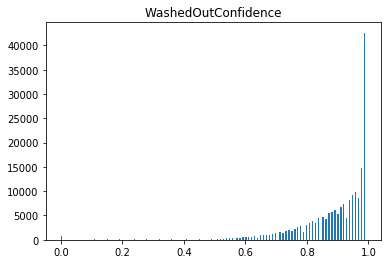

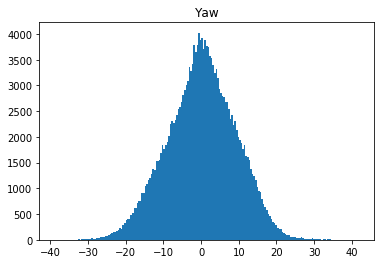

In [38]:
def plot_scalars(scalar_stats):
    for label, scalar_list in scalar_stats.items():
        if np.array(scalar_list).std() == 0: print(label, 'is not labeled')
        else: plot_histogram(np.array(scalar_list), title=label)
plot_scalars(scalar_stats)

### Prepare

In [39]:
for label, scalar_list in scalar_stats.items():
    if label in 'Yaw Pitch Roll':
        print(label, np.mean(scalar_list), np.std(scalar_list))

Pitch -8.194931663957423 6.060408145596894
Roll -0.9308173492533485 6.677749119932046
Yaw 0.17198330385273794 9.064688131373693


In [40]:
emotion_list = ['EmotionAngerConfidence','EmotionContemptConfidence','EmotionDisgustConfidence','EmotionFearConfidence','EmotionHappinessConfidence','EmotionNeutralConfidence','EmotionSadnessConfidence','EmotionSurpriseConfidence']
ethnicity_list = ['EthnicityAsianConfidence','EthnicityBlackConfidence','EthnicityHispanicConfidence','EthnicityIndianConfidence','EthnicityWhiteConfidence']
liveness_list = ['LivenessScore','LivenessTargetPitch','LivenessTargetYaw']
bad_scalar_list = ['Age', 'BeardConfidence','GenderConfidence','HatConfidence','MustacheConfidence']

In [41]:
scalar_list = set(filter(lambda x: 'scalar' in lbl_config[x][0], lbl_config.keys()))
scalar_list = scalar_list - set(bad_scalar_list) - set(emotion_list) - set(ethnicity_list) - set(liveness_list)
scalar_list

{'BackgroundUniformity',
 'BlinkConfidence',
 'Contrast',
 'DarkGlassesConfidence',
 'DetectionConfidence',
 'ExpressionConfidence',
 'FaceDarknessConfidence',
 'GlassesConfidence',
 'GlassesReflectionConfidence',
 'GrayscaleDensity',
 'LookingAwayConfidence',
 'MouthOpenConfidence',
 'Noise',
 'Pitch',
 'PixelationConfidence',
 'Quality',
 'RedEyeConfidence',
 'Roll',
 'Saturation',
 'Sharpness',
 'SkinReflectionConfidence',
 'UnnaturalSkinToneConfidence',
 'WashedOutConfidence',
 'Yaw'}

In [42]:
multi_list = set(filter(lambda x: 'multi' in lbl_config[x][0], lbl_config.keys()))
multi_list = multi_list - set(['LivenessAction', 'Gender', 'Properties'])
multi_list

{'Expression', 'IcaoWarnings'}

In [43]:
pts_list = set(filter(lambda x: 'pt' in lbl_config[x][0], lbl_config.keys()))
pts_list

{'FeaturePoints', 'LeftEyeCenter', 'MouthCenter', 'NoseTip', 'RightEyeCenter'}

In [44]:
def create_fn2labels_dict():
    out_dict = {}
    for data_name in progress_bar(DNAMES):
        for j in read_json(data_name)['images']:
            im_path, (face1, face2) = j['path'], j['faces']
            face1, face2 = preprocess_face(face1), preprocess_face(face2)
            kwargs = defaultdict(lambda: [])
            for i, (label, l_id) in enumerate(lbl2id.items()):
                if 'scalar' in lbl_config[label][0] and label not in scalar_list: continue
                if 'multi' in lbl_config[label][0] and label not in multi_list: continue
                if 'pt' in lbl_config[label][0] and label not in pts_list: continue
                face = face2 if label in ['Contrast','Noise','Quality'] else face1
                answer = face[l_id]
                kwargs[label].append(answer)
            # map to pytorch tensors
            kwargs = {k:(v, lbl_config[k][0]) for k,v in kwargs.items() if 'multi' not in lbl_config[k][0]}
            kwargs['Labels'] = (['Face'] * len(list(kwargs.values())[0][0]), 'class')
            out_dict[im_path] = kwargs
    return out_dict

In [45]:
fn2labels = create_fn2labels_dict()

In [46]:
save_dict(fn2labels, config.DICT_PATH)

In [47]:
#export
def get_filename2bboxes_dict():
    return read_dict(config.DICT_PATH)

In [48]:
#export
def create_df():
    fn2labels = get_filename2bboxes_dict()
    data = []
    for fn in fn2labels.keys():
        data.append((str(config.IM_PATH/fn), False, 'unlabeled'))
    return pd.DataFrame(data, columns=['image_path', 'valid', 'dataset'])

In [49]:
df = create_df()
df.head()

,image_path,valid,dataset
0,/data/faces/unlabeled/images/sof_1.jpg,False,unlabeled
1,/data/faces/unlabeled/images/sof_724.jpg,False,unlabeled
2,/data/faces/unlabeled/images/sof_404.jpg,False,unlabeled
3,/data/faces/unlabeled/images/sof_1277.jpg,False,unlabeled
4,/data/faces/unlabeled/images/sof_2491.jpg,False,unlabeled


In [50]:
fn2labels = get_filename2bboxes_dict()

In [51]:
list(fn2labels.keys())[0]

'sof_1.jpg'

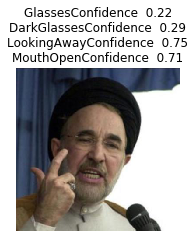

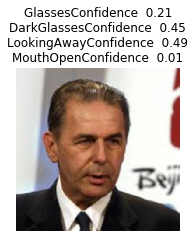

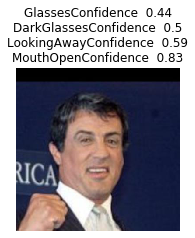

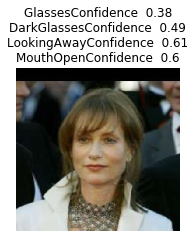

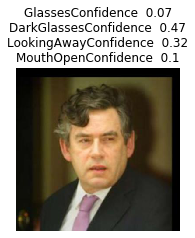

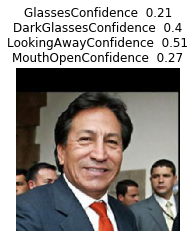

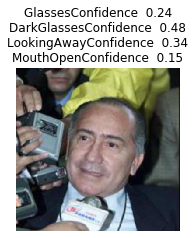

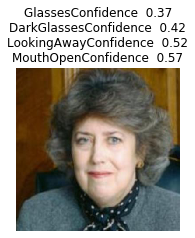

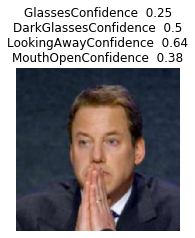

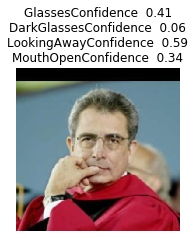

In [ ]:
preds = ['GlassesConfidence','DarkGlassesConfidence','LookingAwayConfidence','MouthOpenConfidence']
for i in np.random.randint(0,10000,size=(10)):
# for i in range(3):
    im_path = df.iloc[i]['image_path']
    fn = im_path.split('/')[-1]
    labels = fn2labels[fn]
    values = [labels[pname][0][0] for pname in preds]
    text = '\n'.join([ k+'  '+str(v) for k,v in zip(preds,values) ])
    open_image(im_path).show(title=text)

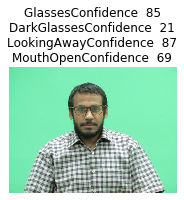

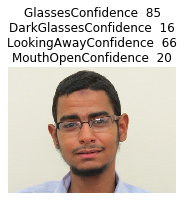

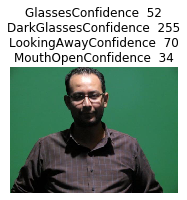

In [ ]:
# raw
for j in read_json('sof')['images'][:3]:
    im_path, (face1, face2) = j['path'], j['faces']
    values = [face1[lbl2id[pname]] for pname in preds]
    text = '\n'.join([ k+'  '+str(v) for k,v in zip(preds,values) ])
    open_image(str(IM_PATH/im_path)).show(title=text)

# Cropped data

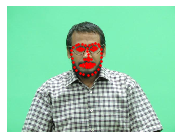

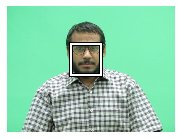

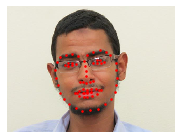

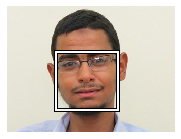

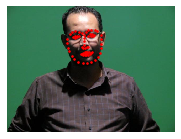

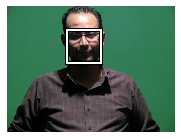

In [ ]:
for i in range(len(df))[:3]:
    im_path = df.iloc[i]['image_path']
    fn = im_path.split('/')[-1]
    labels = fn2labels[fn]
    scalar_values = [labels[pname][0][0] for pname in scalar_list]
#     text = '\n'.join([ k+'  '+str(v) for k,v in zip(scalar_list,scalar_values) ])
    fpts = labels['FeaturePoints'][0][0] # [68,2]
    fpts = [[y,x] for x,y in fpts] # [68,2]
    bbox = labels['BoundingRect'][0][0]
    c,h,w = image.shape
    image = open_image(im_path)
    pts = ImagePoints(FlowField(image.size, tensor(fpts)), scale=True, y_first=True)
    bbox = ImageBBox.create(*image.size, tensor(bbox)[None], scale=True)
    image.show(title=text, y=pts)
    image.show(title=text, y=bbox)

In [53]:
def pad_points(bbox, pad): # pad - tensor([4])
    t,l,b,r = bbox
    h_face, w_face = map(int, [b-t, r-l])
    cc = tensor([(t+b)//2, (l+r)//2])
    offset = (tensor(bbox) - torch.cat([cc,cc])).abs()
    offset = (offset * PAD_PCT).long() # scale
    cc = torch.cat([cc,cc])
    t,l = cc[:2] - offset[:2]
    b,r = cc[2:] + offset[2:]
    return list(map(int, [t,l,b,r]))

In [57]:
indexes = np.random.randint(0,10000,size=(10))
PAD_PCT = tensor([2.0,1.8,1.5,1.8]) # t,l,b,r

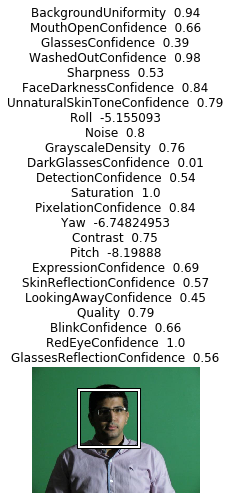

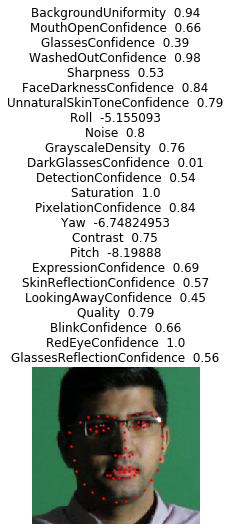

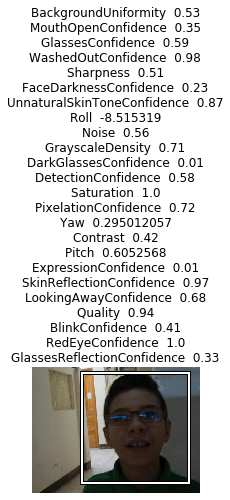

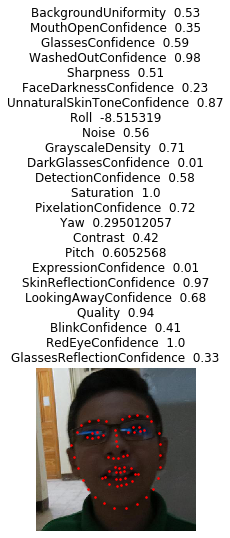

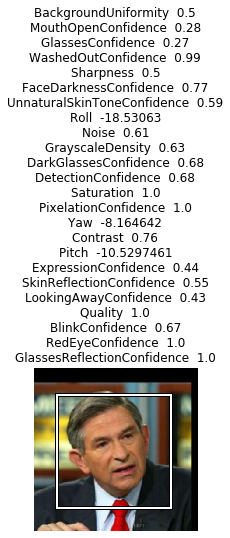

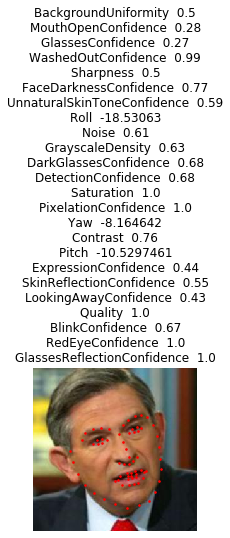

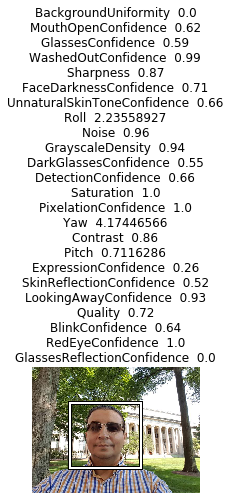

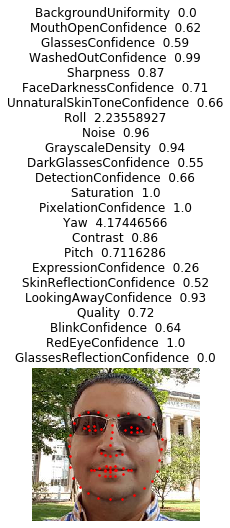

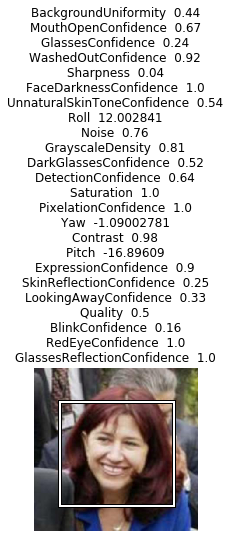

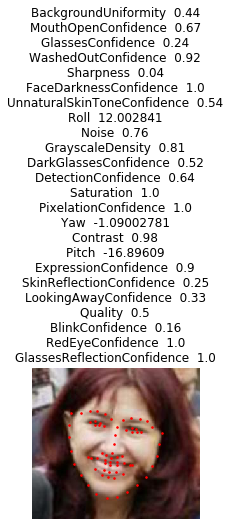

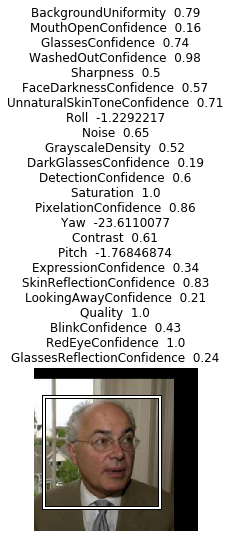

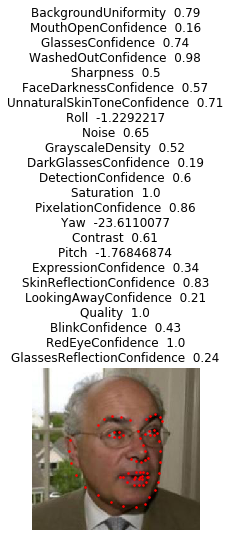

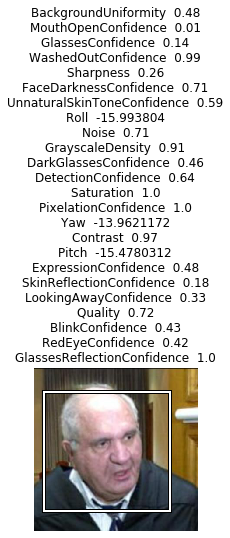

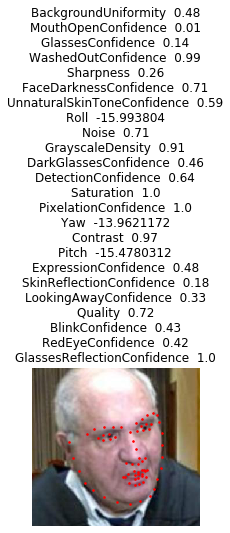

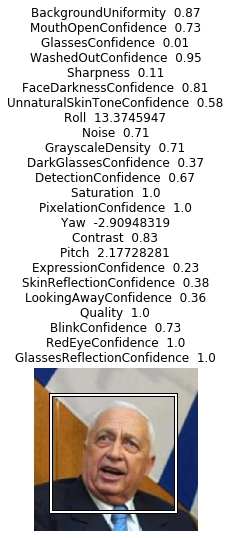

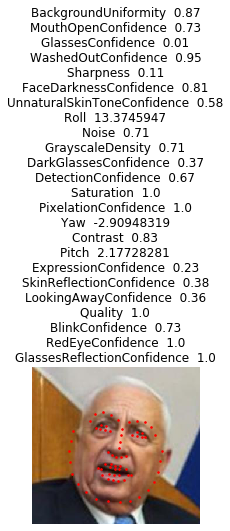

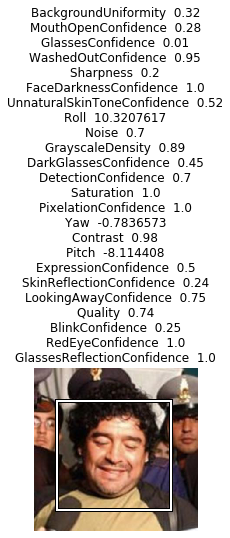

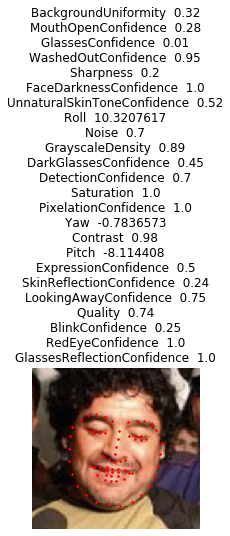

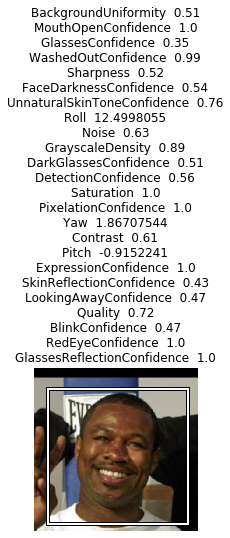

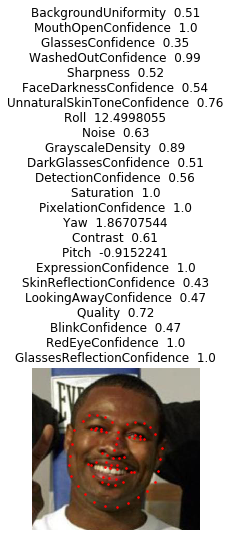

In [58]:
for i in indexes:
    # 1.0 load image and labels
    im_path = df.iloc[i]['image_path']
    image = open_image(im_path)
    c,h,w = image.shape
    fn = im_path.split('/')[-1]
    labels = fn2labels[fn]
    # 2.0 get scalar values
    scalar_values = [labels[pname][0][0] for pname in scalar_list]
    text = '\n'.join([ k+'  '+str(v) for k,v in zip(scalar_list,scalar_values) ])
    # 3.0 get feature point values + bbox rect
    fpts = labels['FeaturePoints'][0][0] # [68,2]
    fpts = tensor([[y,x] for x,y in fpts]) # [68,2]
#     bbox = labels['BoundingRect'][0][0]
    (t, l), (b, r) = fpts.min(dim=0)[0], fpts.max(dim=0)[0] # [0] - values, [1] - idxes
    bbox_orig = list(map(int, [t,l,b,r]))
    t,l,b,r = pad_points((t,l,b,r), PAD_PCT)
    t,l = max(t,0), max(l,0)
    b,r = min(b,h), min(r,w)
    bbox = tensor([t,l,b,r])
    cropped_fpts = fpts - bbox[:2]
    cropped_fpts = [[int(y),int(x)] for y,x in cropped_fpts]
    # show image
    pts = ImagePoints(FlowField(image.size, tensor(fpts)), scale=True, y_first=True)
    bbox_obj = ImageBBox.create(*image.size, tensor(bbox)[None], scale=True)
    image.show(title=text, y=bbox_obj)
    # show cropped image
    cropped_image = Image(image.data[:,t:b,l:r])
    cropped_pts = ImagePoints(FlowField(image.size, tensor(cropped_fpts)), scale=True, y_first=True)
    cropped_image.show(title=text, y=cropped_pts)

In [59]:
def save_cropped_data():
    labels_out = {}
    df = create_df()
    for i in progress_bar(range(len(df))):
        # 1.0 load image and labels
        im_path = df.iloc[i]['image_path']
        image = open_image(im_path)
        c,h,w = image.shape
        fn = im_path.split('/')[-1]
        labels = fn2labels[fn]
        # 2.0 get scalar values
        scalar_values = [labels[pname][0][0] for pname in scalar_list]
    #     text = '\n'.join([ k+'  '+str(v) for k,v in zip(scalar_list,scalar_values) ])
        # 3.0 get feature point values + bbox rect
        fpts = labels['FeaturePoints'][0][0] # [68,2]
        fpts = tensor([[y,x] for x,y in fpts]) # [68,2]
    #     bbox = labels['BoundingRect'][0][0]
        (t, l), (b, r) = fpts.min(dim=0)[0], fpts.max(dim=0)[0] # [0] - values, [1] - idxes
        bbox_orig = list(map(int, [t,l,b,r]))
        t,l,b,r = pad_points((t,l,b,r), PAD_PCT)
        t,l = max(t,0), max(l,0)
        b,r = min(b,h), min(r,w)
        bbox = tensor([t,l,b,r])
        cropped_fpts = fpts - bbox[:2]
        cropped_fpts = [[int(y),int(x)] for y,x in cropped_fpts]
        # save cropped image and labels
        new_labels = {'FeaturePoints': cropped_fpts}
        new_labels['Scalars'] = {k:v for k,v in zip(scalar_list,scalar_values)}
        labels_out[fn] = new_labels
        cropped_image = Image(image.data[:,t:b,l:r])
        cropped_image.save(config.CROPPED_IM_PATH/fn)
    save_dict(labels_out, config.CROPPED_DICT_PATH)

In [60]:
save_cropped_data()

In [ ]:
#export
def get_filename2cropped_dict():
    return read_dict(config.CROPPED_DICT_PATH)

In [ ]:
#export
def create_cropped_data():
    fn2labels = get_filename2cropped_dict()
    data = []
    for fn in fn2labels.keys():
        data.append((str(config.CROPPED_IM_PATH/fn), False, 'unlabeled_cropped'))
    return pd.DataFrame(data, columns=['image_path', 'valid', 'dataset']), fn2labels

In [ ]:
df,_ = create_cropped_data()
df.head()

,image_path,valid,dataset
0,../data/face/unlabeled_cropped_images/sof_1.jpg,False,unlabeled_cropped
1,../data/face/unlabeled_cropped_images/sof_724.jpg,False,unlabeled_cropped
2,../data/face/unlabeled_cropped_images/sof_404.jpg,False,unlabeled_cropped
3,../data/face/unlabeled_cropped_images/sof_1277...,False,unlabeled_cropped
4,../data/face/unlabeled_cropped_images/sof_2491...,False,unlabeled_cropped
